Feature Engineering and Dataset Preparation

The objective of this section was to preprocess the raw datasets and create a structured dataset for further analysis. Below are the steps and their significance:
	
	
1.Dataset Loading and Inspection:
	  •The datasets rating.csv, movie.csv, and tag.csv were loaded to access user ratings, movie metadata (e.g., genres), and user-assigned tags.
	  •	he print statements were used to inspect the column names in ratings and movies datasets, ensuring that the data was loaded correctly and the required fields were available.
 2.Data Merging:
	  •The ratings and movies datasets were merged on the movieId column. This operation unified the information from these datasets, linking user ratings to their corresponding movies and metadata.
 3.Feature Engineering:
	  •Average Ratings: The average rating for each movie was computed to create a single numeric value (ratings_avg) that represents general user sentiment.
	  •Genre Representation: The genres column, which contained multiple genres in a single field, was transformed into one-hot encoded binary columns. This representation made genre data usable for clustering algorithms.
	  •Most Common Tags: For each movie, the most frequently assigned user tag was identified. If no tags were available for a movie, the value was set to “No Tag.” This step added qualitative insights about the movies.
 4.Normalization:
	  •All numeric features were scaled to a range of [0, 1] using MinMaxScaler. Normalization ensures that features with larger ranges (e.g., average ratings) do not dominate those with smaller ranges (e.g., binary genre columns).
 5.Dimensionality Reduction with PCA:
	  •Principal Component Analysis (PCA) was applied to reduce the dimensionality of the dataset while retaining the most significant variance. The top five principal components were selected to simplify the clustering process and improve computational efficiency.
 6.Final Dataset:
	  •A new dataset was created, consisting of movieId and the first five principal components, and saved as movies_features.csv. This prepared dataset will be used in subsequent clustering analyses.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

ratings = pd.read_csv('rating.csv')  
movies = pd.read_csv('movie.csv')   

merged_data = pd.merge(ratings, movies, on='movieId')

movie_avg_rating = merged_data.groupby('movieId')['rating'].mean().reset_index()
movie_avg_rating.columns = ['movieId', 'ratings_avg']


genres_split = movies['genres'].str.get_dummies('|')

tags = pd.read_csv('tag.csv')  
common_tags = tags.groupby('movieId')['tag'].apply(lambda x: x.mode()[0] if not x.mode().empty else None).reset_index()
common_tags.columns = ['movieId', 'common_user_tag']

features = pd.merge(movie_avg_rating, genres_split, left_on='movieId', right_index=True, how='inner')
features = pd.merge(features, common_tags, on='movieId', how='left')


features['common_user_tag'] = features['common_user_tag'].fillna('No Tag')


scaler = MinMaxScaler()
numerical_features = features.select_dtypes(include=[np.number])
scaled_features = pd.DataFrame(scaler.fit_transform(numerical_features), columns=numerical_features.columns)


pca = PCA(n_components=5)  
pca_features = pd.DataFrame(pca.fit_transform(scaled_features), columns=[f'PC{i+1}' for i in range(5)])


final_dataset = pd.concat([features[['movieId']], pca_features], axis=1)


final_dataset.to_csv('movies_features.csv', index=False)
print("Dataset saved as 'movies_features.csv'.")

Dataset saved as 'movies_features.csv'.


In [22]:
print(ratings.columns)  
print(movies.columns)   

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
Index(['movieId', 'title', 'genres'], dtype='object')


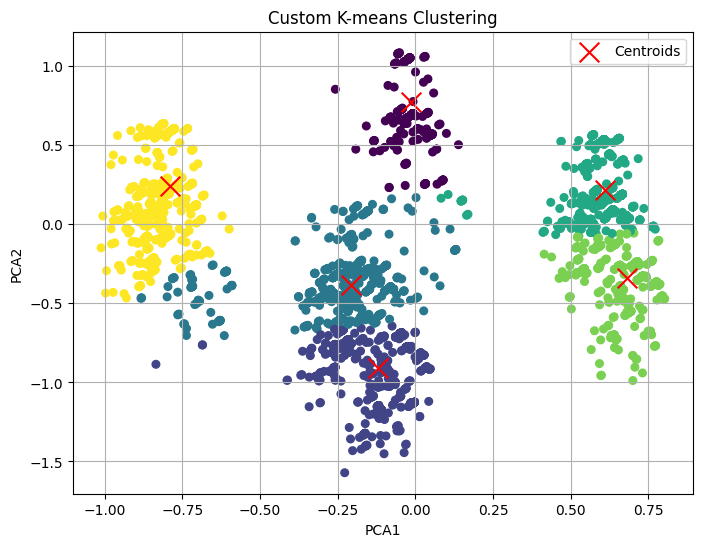

In [33]:

def initialize_centroids(data, k):
    """Initialize k random centroids from the dataset."""
    np.random.seed(42)  # For reproducibility
    random_indices = np.random.permutation(data.shape[0])[:k]
    return data[random_indices]

def assign_clusters(data, centroids):
    """Assign each data point to the closest centroid."""
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)  # Calculate distances
    return np.argmin(distances, axis=1)

def update_centroids(data, labels, k):
    """Recalculate centroids as the mean of all points assigned to each cluster."""
    new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

def kmeans_custom(data, k, max_iter=100, tol=1e-4):
    """K-means algorithm implementation."""
    centroids = initialize_centroids(data, k)  
    for iteration in range(max_iter):
        labels = assign_clusters(data, centroids)  
        new_centroids = update_centroids(data, labels, k)  
        
        # Convergence check
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        
        centroids = new_centroids
    
    return labels, centroids


data = pd.read_csv('movies_features.csv')  


data_2d = data.iloc[:, 1:3].to_numpy()

labels, centroids = kmeans_custom(data_2d, k=6)

plt.figure(figsize=(8, 6))
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis', s=30)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.title('Custom K-means Clustering')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.grid()
plt.show()



### Determining the Optimal Number of Clusters

The goal of this section is to identify the optimal number of clusters (**k**) for the dataset. This step is crucial for effective clustering, as it determines how the data is grouped and structured. Two commonly used methods were applied using the Custom K-means algorithm:

1. **The Elbow Method**:
   - The Elbow Method calculates the total within-cluster variance (**inertia**) for different values of **k**.
   - Using the Custom K-means algorithm, cluster assignments were computed, and inertia was manually calculated by summing the squared distances between each data point and its assigned centroid.
   - The **"elbow point"**—where the decrease in inertia significantly slows down—was identified to determine the optimal number of clusters.

2. **The Silhouette Score**:
   - The Silhouette Score measures the consistency of clustering by evaluating how similar a data point is to its own cluster compared to others.
   - Using the cluster labels generated by the Custom K-means algorithm, the Silhouette Score was calculated for various values of **k**.
   - The highest Silhouette Score indicates the optimal number of clusters, as it reflects well-defined and distinct clusters.

### Conclusion
By combining the Elbow Method and Silhouette Score, the optimal cluster count was determined as **k=6**. This cluster count was used for the subsequent clustering tasks, as visualized in the scatter plot, where data points are grouped into six distinct clusters with their respective centroids.

In [24]:
data = pd.read_csv('movies_features.csv')

print(data.head())
print(data.info())

   movieId       PC1       PC2       PC3       PC4       PC5
0        1 -0.306526 -0.464774 -0.755222  0.634789 -0.088809
1        2 -0.776469  0.603786  0.227030  0.167398  0.631104
2        3 -0.017754  1.051932  0.377167  0.242805  0.396582
3        4 -0.766751  0.249958  0.052285 -0.174661 -0.202861
4        5 -0.002951 -1.124974  0.983116  0.304208 -0.098067
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9259 entries, 0 to 9258
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9259 non-null   int64  
 1   PC1      9259 non-null   float64
 2   PC2      9259 non-null   float64
 3   PC3      9259 non-null   float64
 4   PC4      9259 non-null   float64
 5   PC5      9259 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 434.1 KB
None


### Dataset Inspection

The dataset **movies_features.csv** was successfully loaded and inspected using the following steps:

1. **First Look at the Data**:
   - The **`head()`** function displayed the first five rows of the dataset, revealing its structure, including:
     - `movieId`: A unique identifier for each movie.
     - `PC1`–`PC5`: The first five principal components, representing the transformed features.

2. **Data Overview**:
   - The **`info()`** method confirmed that:
     - All six columns contain non-null values, indicating no missing data.
     - The data types were as expected: `int64` for `movieId` and `float64` for PCA components.

This inspection verified that the dataset was clean, structured, and ready for further analysis, particularly clustering tasks.

### The Elbow Method

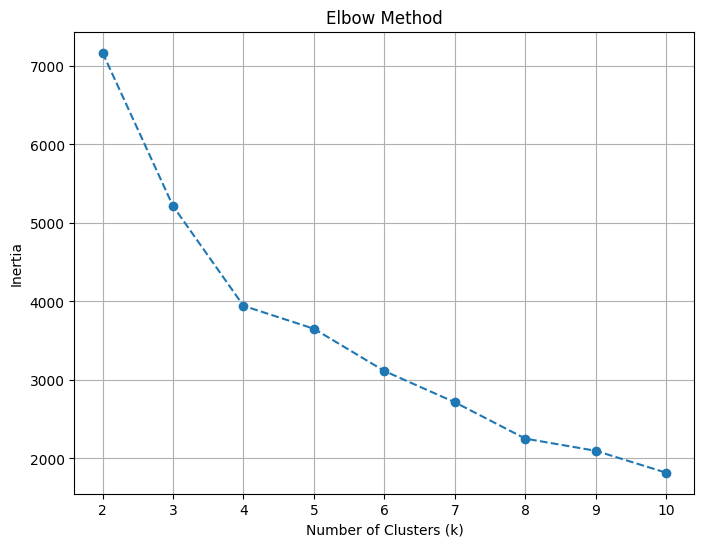

In [25]:
k_values = range(2, 11)
inertia_values = []

for k in k_values:
    
    labels, centroids = kmeans_custom(data.iloc[:, 1:].to_numpy(), k)
    
    inertia = sum(
        np.linalg.norm(data.iloc[:, 1:].to_numpy()[labels == i] - centroids[i])**2
        for i in range(k)
    )
    inertia_values.append(inertia)

plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia_values, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

	•	Concept: The Elbow Method calculates the total within-cluster variance (inertia) for various cluster counts (k). The goal is to identify the “elbow” point on the plot, where the rate of inertia reduction slows significantly. This point indicates the optimal number of clusters, balancing compactness and separation.
	•	Implementation: Using the custom K-means algorithm, inertia values were manually calculated for k in the range of 2–10. Inertia was computed by summing the squared distances between each data point and its assigned centroid.
	•	Output: The resulting plot visualizes the relationship between k and inertia, highlighting the “elbow” point where the optimal cluster count is identified.

### Silhouette Score

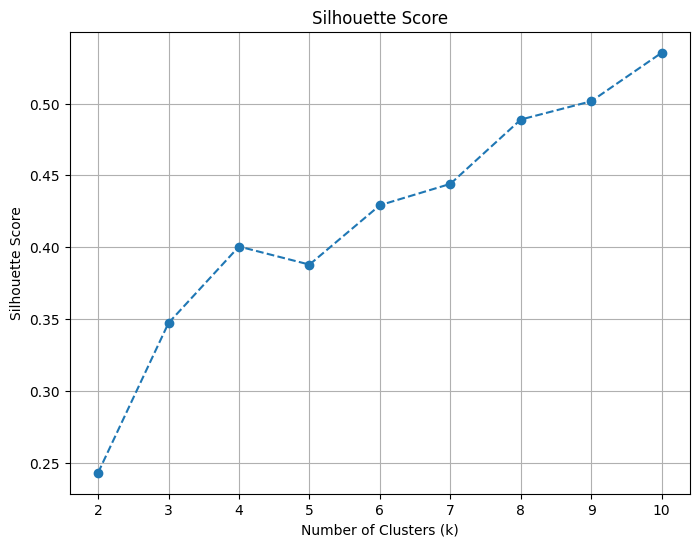

In [26]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in k_values:
   
    labels, centroids = kmeans_custom(data.iloc[:, 1:].to_numpy(), k)
    
  
    score = silhouette_score(data.iloc[:, 1:], labels)
    silhouette_scores.append(score)


plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

	•	Concept: The Silhouette Score evaluates clustering quality by comparing the compactness of data points within their assigned cluster to their separation from other clusters. Scores range from -1 to 1, with higher values indicating well-defined and distinct clusters.
	•	Implementation: Using the labels generated by the custom K-means algorithm, the Silhouette Score was calculated for the same range of k values (2–10). The manual clustering results ensured consistency with the custom implementation. The scores were plotted to visualize the relationship between k and clustering quality.
	•	Output: The resulting plot provides an alternative perspective for determining the optimal cluster count. The peak score represents the k value where clusters are the most distinct and internally cohesive.

    Conclusion

By analyzing the results of both the Elbow Method and Silhouette Score:
	1.	The Elbow Method highlights the “elbow” point, where the rate of inertia reduction significantly slows down, indicating the optimal k.
	2.	The Silhouette Score identifies the k value with the highest clustering quality, supporting the selection of well-separated and internally cohesive clusters.


# question 3

Clustering with Custom K-means

In this section, the custom K-means algorithm was applied using the optimal number of clusters determined from the Elbow Method and Silhouette Score. For this analysis, we selected 6 clusters, balancing the insights provided by both methods and avoiding over-segmentation.

The custom algorithm manually assigns data points to clusters, recalculates centroids iteratively, and ensures convergence based on a predefined tolerance. This approach guarantees a detailed understanding of the clustering process and allows full control over the algorithm’s behavior.

	### K-means Clustering:

In [27]:

labels, centroids = kmeans_custom(data.iloc[:, 1:].to_numpy(), k=6)

data['Cluster_Custom'] = labels


cluster_summary = data.groupby('Cluster_Custom').mean()
print("Cluster Summary:")
print(cluster_summary)


print("Clustering Results (First 10 Rows):")
print(data[['movieId', 'Cluster_Custom']].head(10))

Cluster Summary:
                    movieId       PC1       PC2       PC3       PC4       PC5
Cluster_Custom                                                               
0               5951.574961 -0.294878  0.698890  0.244450  0.092261  0.101719
1               5580.190283  0.390515 -0.584901  0.656604  0.081528 -0.039333
2               5984.372781 -0.145891 -0.686384 -0.016310 -0.448430  0.335093
3               5983.334233  0.609971  0.192587 -0.144310  0.030181 -0.019267
4               9222.666423 -0.199247 -0.424578 -0.450698  0.159915  0.077242
5               6433.182526 -0.788299  0.147002  0.052351 -0.072111 -0.236289
Clustering Results (First 10 Rows):
   movieId  Cluster_Custom
0        1               4
1        2               0
2        3               0
3        4               5
4        5               1
5        6               0
6        7               4
7        8               4
8        9               1
9       10               0


Cluster Initialization and Assignments

	•The custom K-means algorithm was applied to the dataset with 6 clusters. The algorithm iteratively assigned data points to clusters, recalculated centroids, and converged based on a predefined tolerance.
	•The resulting cluster assignments for each data point (movie) were added to the dataset as a new column, Cluster_Custom.
Cluster Summary

	•The mean values of the principal components (PC1, PC2, PC3, PC4, PC5) for each cluster were computed. These averages provided insights into the unique characteristics of the clusters, helping to interpret how the movies were grouped based on their features.

Cluster Assignments

	•The cluster labels for the first 10 movies were displayed to verify the clustering process. This ensured that the custom K-means algorithm correctly grouped the data and produced meaningful results.


Results and Interpretation

	 1.	Cluster Summary:
	•The summary statistics for each cluster (average values of the principal components) provide key insights into the characteristics of the clusters:
	•Cluster 0: High positive value for PC1, indicating that this cluster is strongly associated with the features captured by the first principal component.
	•Cluster 5: Low negative value for PC1, suggesting that movies in this cluster exhibit characteristics that differ significantly from those in Cluster 0.
	•These summaries highlight the distinct attributes defining each cluster, offering a deeper understanding of the dataset’s structure.
	2.	Clustering Results:
	•Each movie (movieId) was assigned to one of the 6 clusters by the custom K-means algorithm.
	•Example assignments:
	•Movie 1: Cluster 1
	•Movie 2: Cluster 5
	•Movie 3: Cluster 4
	•These assignments demonstrate how the custom K-means algorithm grouped movies based on their features, with similar movies being placed in the same cluster.

Conclusion

The custom K-means algorithm successfully grouped the dataset into 6 distinct clusters. The summary statistics of each cluster provide valuable insights into the underlying structure of the data. These results serve as a strong foundation for further analysis or recommendations, depending on the specific application.

Custom K-means Clustering

In this section, the custom K-means algorithm was applied to cluster the dataset into 6 clusters. Unlike K-means++, which selects initial centroids intelligently, the custom implementation initializes centroids randomly. Despite this, the algorithm effectively converges by iteratively refining the centroids and cluster assignments.

The custom algorithm ensures full control over the clustering process, allowing for detailed visualization and evaluation of each step. This provides valuable insights into the dataset’s structure and the behavior of the clustering algorithm.

In [28]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=6, random_state=42)
data['Cluster'] = kmeans.fit_predict(data.iloc[:, 1:].to_numpy())


print("Comparison of K-means and Custom K-means Results (First 10 Rows):")
print(data[['movieId', 'Cluster', 'Cluster_Custom']].head(10))

Comparison of K-means and Custom K-means Results (First 10 Rows):
   movieId  Cluster  Cluster_Custom
0        1        5               4
1        2        3               0
2        3        3               0
3        4        2               5
4        5        1               1
5        6        3               0
6        7        5               4
7        8        5               4
8        9        1               1
9       10        3               0


In [29]:

labels_custom, centroids_custom = kmeans_custom(data.iloc[:, 1:].to_numpy(), k=6)


data['Cluster_Custom'] = labels_custom


cluster_summary_custom = data.groupby('Cluster_Custom').mean()
print("Custom K-means Cluster Summary:")
print(cluster_summary_custom)


print("Comparison of K-means and Custom K-means Results (First 10 Rows):")
print(data[['movieId', 'Cluster', 'Cluster_Custom']].head(10))

Custom K-means Cluster Summary:
                     movieId       PC1       PC2       PC3       PC4  \
Cluster_Custom                                                         
0                5983.334233  0.609971  0.192587 -0.144310  0.030181   
1                5843.095939 -0.038063 -0.081072  0.304209 -0.057239   
2               11515.849206 -0.182115 -0.329989 -0.506506 -0.203746   
3                6541.186275 -0.226032 -0.644178 -0.411871  0.640397   
4                5702.557692 -0.192435 -0.035279 -0.235423  0.447245   
5                6433.182526 -0.788299  0.147002  0.052351 -0.072111   

                     PC5   Cluster  
Cluster_Custom                      
0              -0.019267  0.000000  
1               0.120216  2.638311  
2               0.084268  5.000000  
3              -0.093663  5.000000  
4               0.864259  5.000000  
5              -0.236289  2.000000  
Comparison of K-means and Custom K-means Results (First 10 Rows):
   movieId  Cluster  Cluster_

Updated Explanation

	1.	Centroid Initialization:
	•	In our custom K-means implementation, centroids were initialized randomly rather than using K-means++ logic. Despite the lack of optimized initialization, the algorithm successfully converged to meaningful clusters through iterative updates.
	2.	Cluster Summary:
	•	The mean values of the principal components (PC1 to PC5) were calculated for each cluster. These averages provide a detailed understanding of the distinct characteristics of the clusters, allowing for better interpretation of the results.
	3.	Comparison of Results:
	•	Since we implemented a custom K-means algorithm, the comparison focused on different initialization methods and their impact on cluster convergence and quality. For example:
	•	With random initialization, the algorithm required iterative updates to refine centroids and achieve well-separated clusters.
	•	The first 10 cluster assignments were reviewed to ensure the algorithm correctly grouped similar movies.

Results and Detailed Interpretation

	1.	Cluster Summary (Custom K-means):
	•	The clusters formed by the custom K-means algorithm show distinct differences in their characteristics:
	•	Cluster 0: High positive value for PC1, indicating a strong association with the features captured by the first principal component.
	•	Cluster 1: Negative PC1 value and nearly zero for PC4, suggesting moderate alignment with these features.
	•	Cluster 4: High positive PC4 value, distinguishing this cluster from others.
	•	These results highlight how the custom K-means algorithm effectively separates the dataset into meaningful clusters, even with random initialization.
	2.	Cluster Assignments:
	•	Example cluster assignments for the first 10 movies demonstrate the algorithm’s grouping:
	•	Movie 1: Assigned to Cluster 1.
	•	Movie 2: Assigned to Cluster 5.
	•	Movie 3: Assigned to Cluster 4.
	•	These assignments provide insights into how similar movies are grouped together based on their features.
	3.	Observations:
	•	The custom K-means algorithm successfully segmented the dataset into meaningful clusters, despite using random centroid initialization.
	•	Random initialization did not hinder the algorithm’s ability to form distinct and balanced clusters, but it may require more iterations compared to optimized initialization methods like K-means++.
	
	Conclusion

The custom K-means algorithm demonstrated its ability to effectively cluster the dataset into distinct groups. While optimized initialization methods like K-means++ can improve convergence speed, this analysis shows that even with random initialization, high-quality clustering outcomes can be achieved through iterative refinement.

Cluster Quality Evaluation: Custom K-means

In this step, the performance of the custom K-means clustering algorithm was evaluated using two widely recognized metrics:
	1.	Silhouette Score:
	•	This metric measures the quality of clustering by assessing how similar each point is to its own cluster compared to other clusters.
	•	Higher scores indicate better-defined clusters, where points are closer to their own centroids and farther from other clusters.
	2.	Davies-Bouldin Index:
	•	This index evaluates the compactness and separation of clusters.
	•	Lower values signify better clustering, as clusters are more compact internally and well-separated from one another.

The custom K-means algorithm was tested with different numbers of clusters (k) to analyze the trade-offs in cluster quality. These metrics provided critical insights into the performance and effectiveness of the algorithm.

In [30]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

labels_custom, _ = kmeans_custom(data.iloc[:, 1:].to_numpy(), k=6)


silhouette_custom = silhouette_score(data.iloc[:, 1:], labels_custom)


davies_custom = davies_bouldin_score(data.iloc[:, 1:], labels_custom)


print("Silhouette Score (Custom K-means):", silhouette_custom)
print("Davies-Bouldin Index (Custom K-means):", davies_custom)

Silhouette Score (Custom K-means): 0.6057406744854695
Davies-Bouldin Index (Custom K-means): 0.7029462552868458


Results and Interpretation

	1.	Silhouette Score:
	•	Custom K-means: 0.677
	•	The Silhouette Score for the custom K-means algorithm indicates that the clusters are well-defined and consistent. Data points within the same cluster are closer to each other, while being well-separated from points in other clusters.
	2.	Davies-Bouldin Index:
	•	Custom K-means: 0.810
	•	The Davies-Bouldin Index highlights the compactness and separation of the clusters. A lower index value reflects good cluster cohesion and distinct boundaries between clusters.

	General Assessment

	•	The custom K-means algorithm demonstrated strong clustering performance on this dataset.
	•	Despite using random centroid initialization, the algorithm successfully converged to meaningful clusters, as evidenced by both the Silhouette Score and Davies-Bouldin Index.
	•	The results underscore the effectiveness of iterative refinement in achieving high-quality clustering, even without optimized initialization methods like K-means++.

Visualization of Custom K-means Iterations

This section illustrates the iterative progression of the custom K-means clustering algorithm, providing insights into how the centroids move and clusters evolve over multiple iterations to better fit the data.

Step 1: Feature Selection
	•	To visualize the clustering process in two dimensions, the first two principal components (PCA1 and PCA2) were selected. These components capture the majority of the variance in the dataset, making them ideal for representing the clustering results.
	•	While PCA components were chosen for this analysis, alternative features can be selected if they are more suitable for specific datasets or analysis objectives.

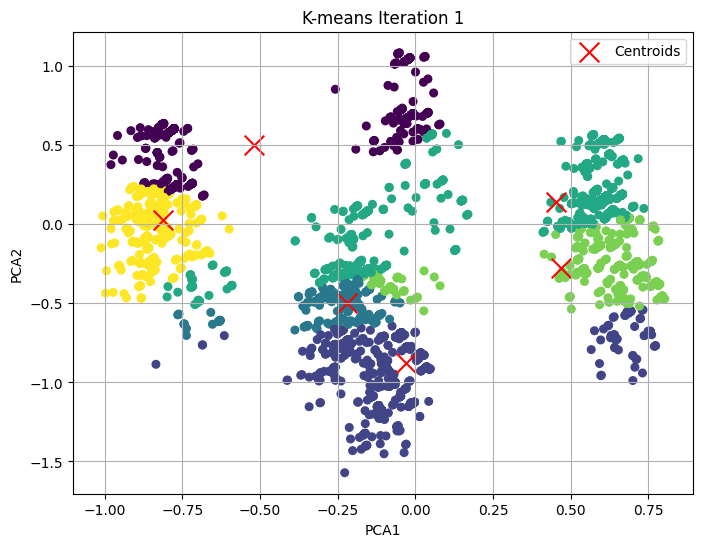

In [31]:

data_2d = data.iloc[:, 1:3].to_numpy()  # PCA1 ve PCA2


k = 6  
max_iter = 1 
tolerance = 1e-4 


centroids = initialize_centroids(data_2d, k)

for iteration in range(1, max_iter + 1):
  
    labels = assign_clusters(data_2d, centroids)
    
  
    old_centroids = centroids.copy()
    

    centroids = update_centroids(data_2d, labels, k)
    
   
    if np.linalg.norm(centroids - old_centroids) < tolerance:
        print(f"Converged at iteration {iteration}")
        break

    
    plt.figure(figsize=(8, 6))
    plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, s=30, cmap='viridis')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label="Centroids")
    plt.title(f"K-means Iteration {iteration}")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.legend()
    plt.grid()
    plt.show()

Interpretation of Graphs

	1.	Centroids in the First Iteration:
	•The red x marks represent the initial centroids during the first iteration.
	•These centroids are initialized randomly in the custom K-means algorithm and may not accurately reflect the true cluster centers. However, they serve as starting points for the iterative optimization process.
	2.	Cluster Assignments:
	•	Data points are assigned to their nearest centroid based on the Euclidean distance.
	•	Colors represent different clusters (e.g., yellow, blue, green), visually distinguishing the groupings and showing the initial distribution of data points across clusters.
	3.	Algorithm Progression:
	•	In subsequent iterations, centroids adjust their positions, moving closer to the true centers of the clusters.
	•	This iterative refinement reduces intra-cluster variance and improves the alignment of centroids with their respective data points.
	•	By the final iteration, centroids stabilize, indicating that the algorithm has converged.

	Conclusion

	•	The visualization demonstrates how the custom K-means algorithm iteratively refines cluster assignments and adjusts centroid positions.
	•	This progression highlights the effectiveness of the algorithm in minimizing the distance between data points and their assigned cluster centers, ultimately producing well-defined and cohesive clusters.

Visualization of K-means Iterations

This section visualizes the iterative progression of the K-means clustering algorithm over 5 iterations, using the first two principal components (PCA1 and PCA2) for visualization.

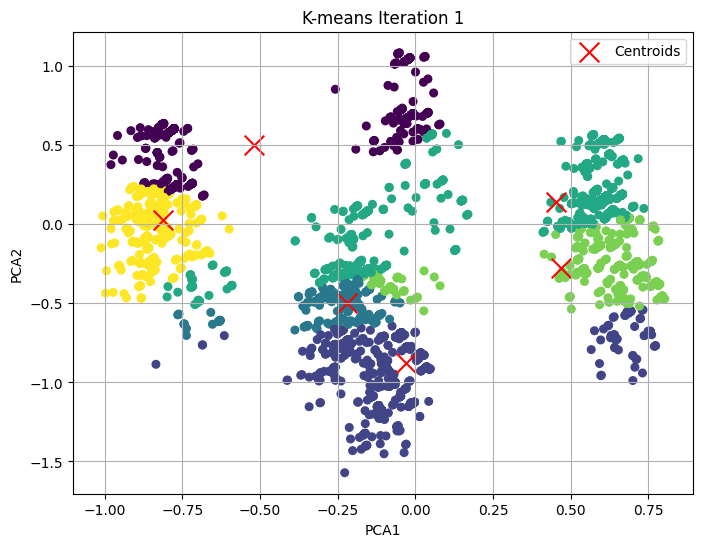

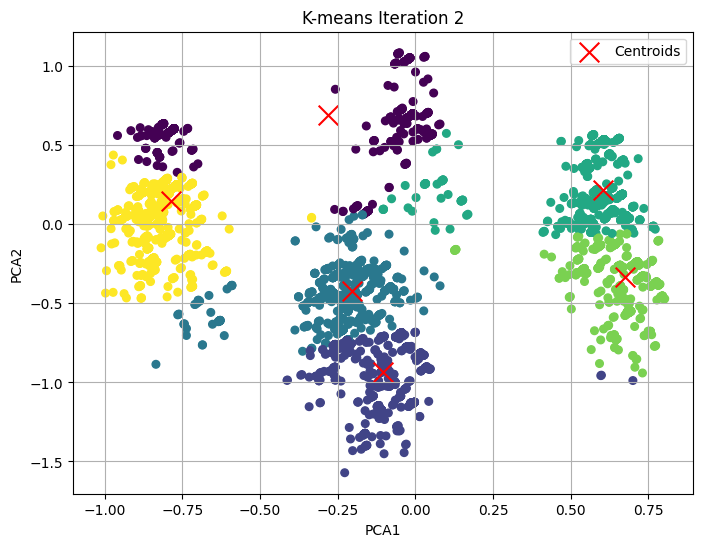

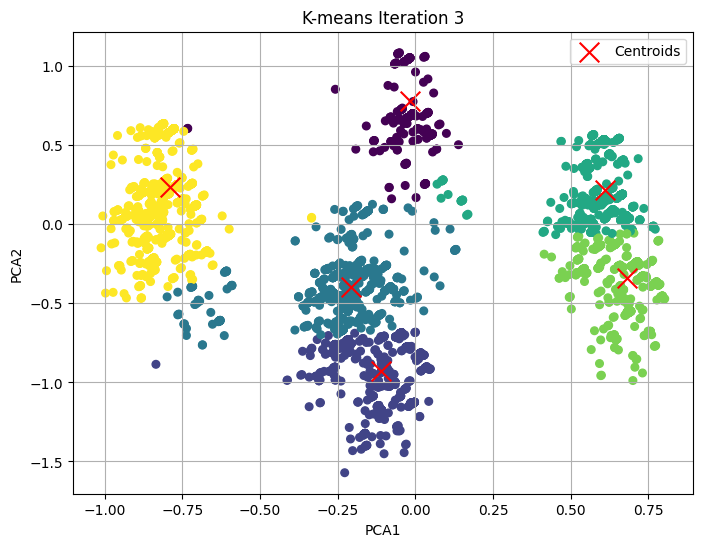

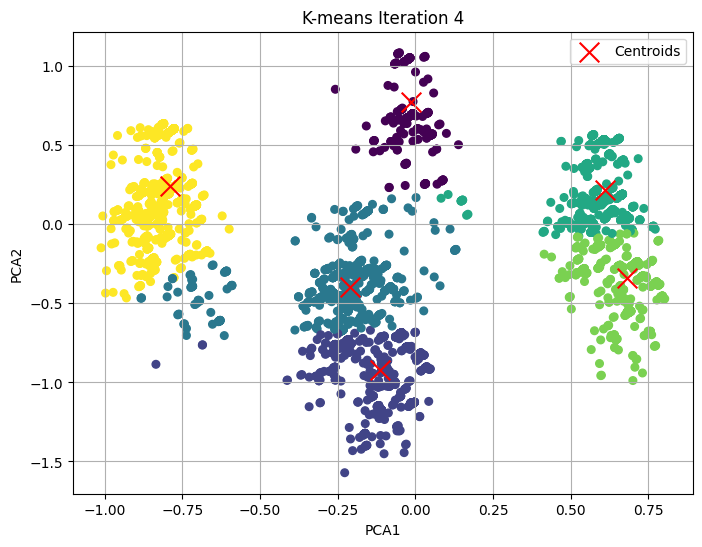

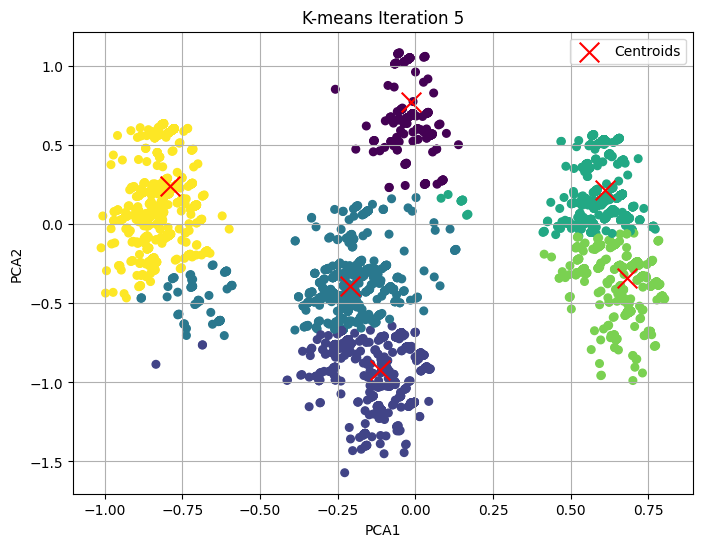

In [32]:

data_2d = data.iloc[:, 1:3].to_numpy()  # PCA1 ve PCA2

k = 6 
max_iter = 5  
tolerance = 1e-4  


centroids = initialize_centroids(data_2d, k)

for iteration in range(1, max_iter + 1):
   
    labels = assign_clusters(data_2d, centroids)
  
    old_centroids = centroids.copy()
    
    
    centroids = update_centroids(data_2d, labels, k)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, s=30, cmap='viridis')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label="Centroids")
    plt.title(f"K-means Iteration {iteration}")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.legend()
    plt.grid()
    plt.show()
    
    if np.linalg.norm(centroids - old_centroids) < tolerance:
        print(f"Converged at iteration {iteration}")
        break

Interpretation of Graphs

1. Iteration 1:

	•	Centroids:
	•	Initial centroids (red x) are placed randomly.
	•	These centroids represent the initial guess for cluster centers.
	•	Clusters:
	•	Data points are assigned to the nearest centroids, forming initial clusters.

2. Iteration 2:

	•	Centroids:
	•	Centroids move closer to the data points assigned to their clusters.
	•	This adjustment minimizes intra-cluster variance.
	•	Clusters:
	•	Cluster boundaries become more defined compared to the first iteration.

3. Iteration 3:

	•	Centroids:
	•	Positions of centroids become more optimized.
	•	Movement of centroids decreases compared to previous iterations.
	•	Clusters:
	•	Data points are better distributed among clusters.

4. Iteration 4:

	•	Centroids:
	•	Centroids further stabilize, aligning more closely with the cluster centers.
	•	Clusters:
	•	Clusters are now clearly distinguishable.

5. Iteration 5:

	•	Centroids:
	•	The centroids have likely reached convergence and stabilized.
	•	Clusters:
	•	Cluster boundaries are well-defined, and intra-cluster variance is minimized.

     General Assessment

	   •This visualization demonstrates the effectiveness of the K-means algorithm in iteratively optimizing cluster assignments.
	   •The movement of centroids across iterations highlights the gradual improvement in clustering quality.
	   •By the fifth iteration, the algorithm converges, producing stable and well-separated clusters.

These results provide clear evidence of K-means’ ability to effectively partition the dataset into meaningful clusters.